In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm


/home/strrl/Project/7375/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("train.csv")

In [3]:
df = pd.read_csv("train.csv")

df = df[["comment_text", "toxic"]]

# balance the dataset
df_toxic = df[df["toxic"] == 1].sample(n=5000,random_state=42)
df_non_toxic = df[df["toxic"] == 0].sample(n=5000,random_state=42)

df_sample = pd.concat([df_toxic, df_non_toxic]).sample(frac=1,random_state=42)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [7]:
print(model.device)

cuda:0


In [8]:
def batch_predict(texts, batch_size=8):
    all_probs = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            toxic_probs = probs[:, 0]  
            all_probs.extend(toxic_probs)
    
    return all_probs

df_sample["toxic_score"] = batch_predict(df_sample["comment_text"].tolist())

100%|██████████| 1250/1250 [00:23<00:00, 53.59it/s]


In [16]:
y_true = df_sample["toxic"].values
y_score = df_sample["toxic_score"].values
y_pred = (y_score >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("ROC AUC:", roc_auc_score(y_true, y_score))

precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)

print("PR AUC:", pr_auc)



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5000
           1       0.99      0.93      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

ROC AUC: 0.99634316
PR AUC: 0.9959465284106328


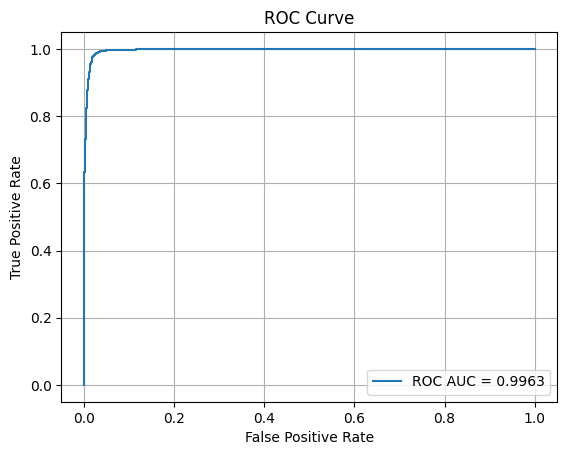

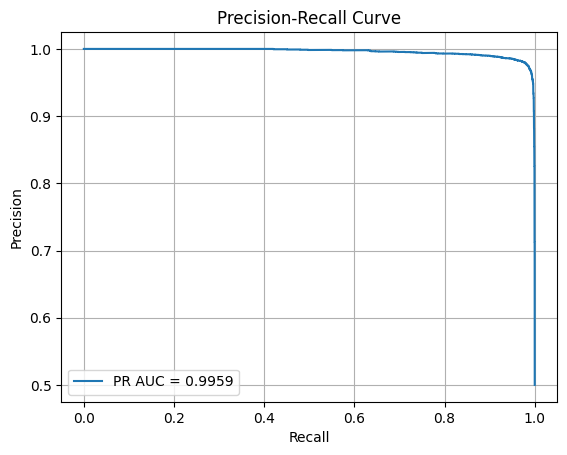

In [18]:
# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.plot(fpr, tpr, label=f"ROC AUC = {auc(fpr, tpr):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_true, y_score)
plt.plot(rec, prec, label=f"PR AUC = {auc(rec, prec):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")x
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()